In [1]:
#!pip install pyepw
#!pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gpflow
import time
import seaborn

from gpflow.utilities import print_summary
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [3]:
def cwc(Y, predX_mean, predX_var, scaler, mu = 0.5, eta = 50):
    testY = scaler.inverse_transform(Y)
    UB = scaler.inverse_transform(predX_mean + 1.96*np.sqrt(predX_var))
    LB = scaler.inverse_transform(predX_mean - 1.96*np.sqrt(predX_var))
    RMSE = np.sqrt(mse(testY,scaler.inverse_transform(predX_mean)))
    CV = RMSE/np.mean(testY)
    coverage = (testY < UB) & (testY > LB)
    picp = np.sum(coverage) / len(testY)
    mpiw = np.sum(UB-LB) / len(testY)
    nmpiw = mpiw / (testY.max() - testY.min())
    gamma = 0 if picp >= mu else 1
    cwc = nmpiw + gamma*np.exp(-eta * (picp-mu))
    return cwc, picp, nmpiw, RMSE, CV

In [4]:
data = pd.read_csv('../data/energy/energyMeter.csv',index_col=0,parse_dates=True)
d = pd.read_csv('../data/energy/dailyEnergy.csv')
d['Temp_std'] = data.groupby(by='date')['P53 OutdoorTempAve'].std().to_numpy()
d = d.iloc[:-3] # end of experiment
d = d[~(d['label_date'].isin(['May 23','Jul 18','Jul 23','Aug 01','Aug 02','Aug 06','Aug 07','Aug 12','Aug 16']))] # incomplete data

In [5]:
base = d[d['is_MMV']=='No']
mmv = d[d['is_MMV']=='Yes']

## best model so far regarding leave-one-out cross validation
best model without Aug data
- feature: average outdoor temperature, total rain hours, variance of outdoor temperature, average relative humidity
- kernel: Matern 3/2

best model after finalizing the data
- feature: average outdoor temperature, variance of outdoor temperature, average relative humidity
- kernel: Matern 1/2

In [6]:
inputs = ['P53 OutdoorTempAve','Temp_std','daily_ave_RH']
X = np.asarray(mmv[inputs])
scalerX = StandardScaler()
scalerX.fit(X)
X = scalerX.transform(X)
output = 'ClgRelatedPower_kWh'
Y = np.asarray(mmv[output]).reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

X_mean = []
X_var = []

for i in range(len(mmv)):

    Xs = np.concatenate([X[:i],X[i+1:]])
    Ys = np.concatenate([Y[:i],Y[i+1:]])
    
    # k1 = gpflow.kernels.Matern12(active_dims=[0])
    # k2 = gpflow.kernels.SquaredExponential(active_dims=[1])
    # k3 = gpflow.kernels.SquaredExponential(active_dims=[2])
    # k = k1 * k2 * k3
    # k = gpflow.kernels.Matern12(lengthscales=[1,.1,0.5,.5])
    k = gpflow.kernels.Matern12()
    m1= gpflow.models.GPR(data=(Xs, Ys), kernel=k)
    # print_summary(m1)
    
    opt = gpflow.optimizers.Scipy()
    t = time.time()
    opt_logs = opt.minimize(m1.training_loss, m1.trainable_variables, options=dict(maxiter=100))

    predX_mean, predX_var = m1.predict_f(X[i].reshape(1,-1))
    X_mean.append(predX_mean[0])
    X_var.append(predX_var[0])

print('test',cwc(Y, X_mean, X_var, scalerY))

test (0.45170700657101115, 0.8970588235294118, 0.45170700657101115, 10.562787549771743, 0.14692715380946283)


#### visualization of daily prediction results

0.6785442837473881

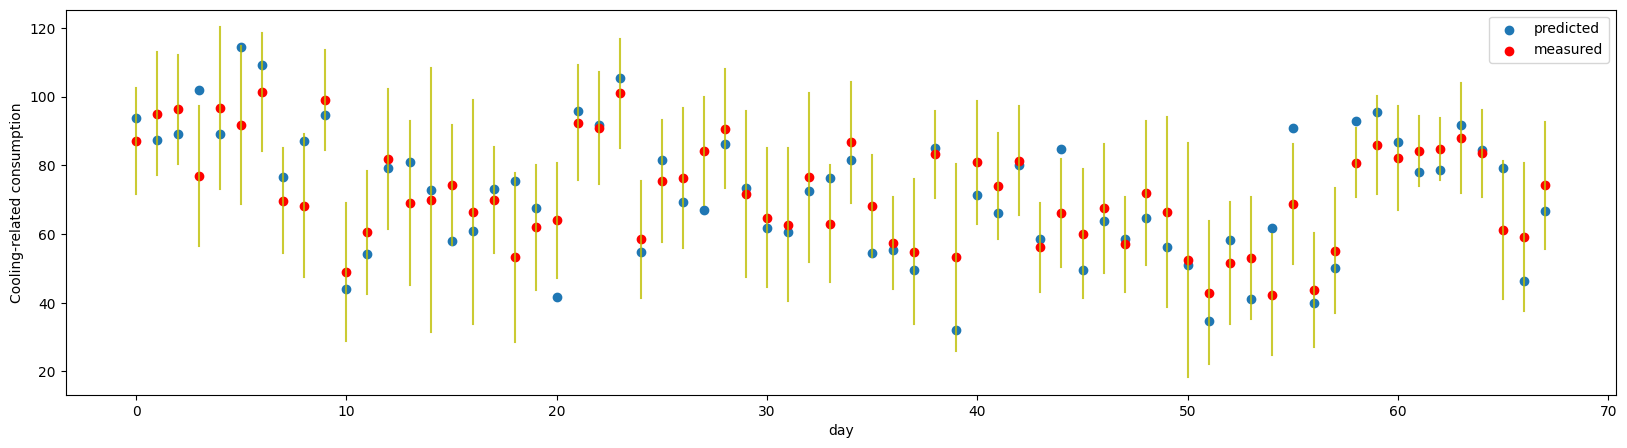

In [7]:
UB = scalerY.inverse_transform(X_mean + 1.96*np.sqrt(X_var))
LB = scalerY.inverse_transform(X_mean - 1.96*np.sqrt(X_var))

fig,ax = plt.subplots(figsize=(20,5))
plt.scatter(np.arange(len(Y)),scalerY.inverse_transform(Y),label='predicted')
for i in range(len(Y)):
    plt.plot([i,i],[UB[i],LB[i]],c='y',alpha=.8)
plt.scatter(np.arange(len(Y)),scalerY.inverse_transform(X_mean),c='r',label='measured')
plt.xlabel('day')
plt.ylabel('Cooling-related consumption')
plt.legend()
r2_score(Y, X_mean)

## energy saving estimation using historical data

#### best MMV model applied on early days with AC24

In [8]:
inputs = ['P53 OutdoorTempAve','Temp_std','daily_ave_RH']
X = np.asarray(mmv[inputs])#[train,:]
scalerX = StandardScaler()
scalerX.fit(X)
X = scalerX.transform(X)
output = 'ClgRelatedPower_kWh'
Y = np.asarray(mmv[output]).reshape(-1,1)#[train,:]
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

k = gpflow.kernels.Matern12()
m1= gpflow.models.GPR(data=(X, Y), kernel=k)
# print_summary(m1)

opt = gpflow.optimizers.Scipy()
t = time.time()
opt_logs = opt.minimize(m1.training_loss, m1.trainable_variables, options=dict(maxiter=100))

In [9]:
testX = scalerX.transform(np.asarray(base[inputs]))
predX_mean, predX_var = m1.predict_f(testX)

base['pred_MMV'] = scalerY.inverse_transform(predX_mean).reshape(1,-1)[0]

C:\Users\bdgleiy.NUSSTF\AppData\Local\Temp\ipykernel_25476\3668274483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['pred_MMV'] = scalerY.inverse_transform(predX_mean).reshape(1,-1)[0]


In [10]:
# print('predicted MMV energy consumption sum up to %f of the AC24 consumption'%(576.763327/1233.000000))
print('predicted MMV energy consumption sum up to %f of the AC24 consumption'%(821.614394/1635.220000))

predicted MMV energy consumption sum up to 0.502449 of the AC24 consumption


##### adding the "total_rain_hours" as input yielded 3% more energy saving but 0.4% higher CVRMSE

#### AC24 model applied on days with MMV, using same features for consistency¶

In [11]:
inputs = ['P53 OutdoorTempAve','Temp_std','daily_ave_RH']
# inputs = ['Tout','solar','workday','workhour']
X = np.asarray(base[inputs])#[train,:]
scalerX = StandardScaler()
scalerX.fit(X)
X = scalerX.transform(X)
output = 'ClgRelatedPower_kWh'
Y = np.asarray(base[output]).reshape(-1,1)#[train,:]
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

k = gpflow.kernels.Linear()
m_base= gpflow.models.GPR(data=(X, Y), kernel=k)
# print_summary(m1)

opt = gpflow.optimizers.Scipy()
t = time.time()
opt_logs = opt.minimize(m_base.training_loss, m_base.trainable_variables, options=dict(maxiter=100))

# Predictions
pred_mean, pred_var = m_base.predict_f(X)

# Calculate precision metrics
cwc_value, picp, nmpiw, rmse, cv = cwc(Y, pred_mean, pred_var, scalerY)

# Print results
print("Performance Metrics:")
print(f"CWC: {cwc_value}")
print(f"PICP: {picp}")
print(f"NMPIW: {nmpiw}")
print(f"RMSE: {rmse}")
print(f"CV: {cv}")

Performance Metrics:
CWC: 0.27176449826286064
PICP: 0.5
NMPIW: 0.27176449826286064
RMSE: 6.425321794716522
CV: 0.0471519804898413


In [12]:
testX = scalerX.transform(np.asarray(mmv[inputs]))
predX_mean, predX_var = m_base.predict_f(testX)
mmv['pred_AC'] = scalerY.inverse_transform(predX_mean).reshape(1,-1)[0]

C:\Users\bdgleiy.NUSSTF\AppData\Local\Temp\ipykernel_25476\1991621511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmv['pred_AC'] = scalerY.inverse_transform(predX_mean).reshape(1,-1)[0]


pred_AC                9423.571368
ClgRelatedPower_kWh    4888.610000
dtype: float64

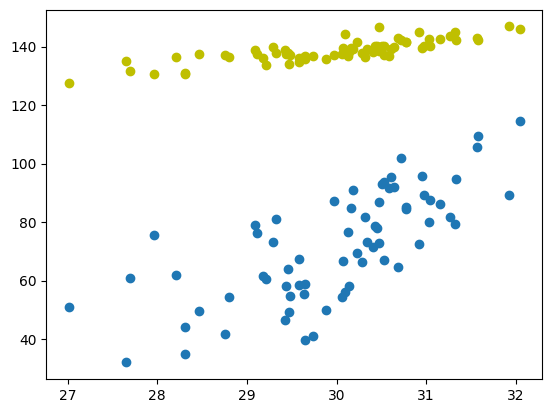

In [13]:
plt.scatter(mmv['P53 OutdoorTempAve'],mmv['pred_AC'],c='y')
plt.scatter(mmv['P53 OutdoorTempAve'],mmv['ClgRelatedPower_kWh'])
mmv[['pred_AC','ClgRelatedPower_kWh']].sum()

In [14]:
print('MMV energy consumption sum up to %f of the predicted AC24 consumption'%(4888.610000/9423.571368))

MMV energy consumption sum up to 0.518764 of the predicted AC24 consumption


## energy saving estimation using 2023 AMY

In [15]:
from pyepw.epw import EPW
epw = EPW()
epw.read('../data/energy/SingaporeAMY2023.epw')

In [16]:
amy23 = []
for wd in epw.weatherdata:
    amy23.append([wd.month, wd.day, wd.dry_bulb_temperature, wd.relative_humidity])
amy23 = pd.DataFrame(amy23,columns=['month','day','P53 OutdoorTempAve','daily_ave_RH'])
amy23['date'] = amy23['month'].astype('str') + '_' + amy23['day'].astype('str')

In [17]:
amy23_daily = amy23.groupby('date')[['P53 OutdoorTempAve','daily_ave_RH']].mean()
amy23_daily['Temp_std'] = amy23.groupby('date')['P53 OutdoorTempAve'].std()

### removed total rain hour as there's no data

In [18]:
inputs = ['P53 OutdoorTempAve','Temp_std','daily_ave_RH']
X = np.asarray(mmv[inputs])
scalerX = StandardScaler()
scalerX.fit(X)
X = scalerX.transform(X)
output = 'ClgRelatedPower_kWh'
Y = np.asarray(mmv[output]).reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

k = gpflow.kernels.Matern12()
m1= gpflow.models.GPR(data=(X, Y), kernel=k)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m1.training_loss, m1.trainable_variables, options=dict(maxiter=100))


X = np.asarray(base[inputs])
X = scalerX.transform(X)
Y = np.asarray(base[output]).reshape(-1,1)
scalerYbase = StandardScaler()
scalerYbase.fit(Y)
Y = scalerYbase.transform(Y)

k = gpflow.kernels.Linear()
m_base= gpflow.models.GPR(data=(X, Y), kernel=k)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_base.training_loss, m_base.trainable_variables, options=dict(maxiter=100))

In [19]:
testX = scalerX.transform(np.asarray(amy23_daily[inputs]))
pred_mmv_mean, pred_mmv_var = m1.predict_f(testX)
pred_ac_mean, pred_ac_var = m_base.predict_f(testX)
amy23_daily['pred_MMV'] = scalerY.inverse_transform(pred_mmv_mean).reshape(1,-1)[0]
amy23_daily['pred_AC'] = scalerYbase.inverse_transform(pred_ac_mean).reshape(1,-1)[0]
amy23_daily['mmv_UB'] = scalerY.inverse_transform(pred_mmv_mean + 1.96*np.sqrt(pred_mmv_var))
amy23_daily['mmv_LB'] = scalerY.inverse_transform(pred_mmv_mean - 1.96*np.sqrt(pred_mmv_var))
amy23_daily.loc[amy23_daily['mmv_LB']<0,'mmv_LB'] = 0

pred_AC     48822.103889
pred_MMV    18830.349061
mmv_LB       9855.846857
dtype: float64

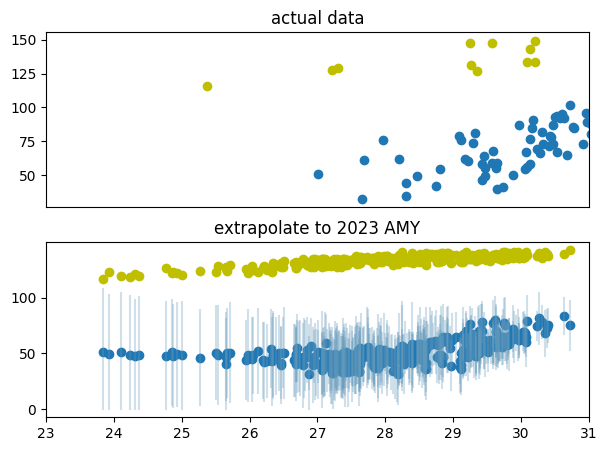

In [20]:
fig, axs = plt.subplots(2,1,figsize=(7,5))
axs[0].scatter(base['P53 OutdoorTempAve'],base['ClgRelatedPower_kWh'],c='y',label='AC24')
axs[0].scatter(mmv['P53 OutdoorTempAve'],mmv['ClgRelatedPower_kWh'],label='MMV')
axs[0].set_xlim(23,31)
axs[0].set_xticks([])
axs[0].set_title('actual data')

axs[1].scatter(amy23_daily['P53 OutdoorTempAve'],amy23_daily['pred_AC'],c='y',label='AC24')
axs[1].scatter(amy23_daily['P53 OutdoorTempAve'],amy23_daily['pred_MMV'],label='MMV')
axs[1].set_xlim(23,31)
axs[1].set_title('extrapolate to 2023 AMY')

## comment out the next 4 lines to remove confidence interval

forPlot = np.asarray(amy23_daily[['P53 OutdoorTempAve','mmv_UB','mmv_LB']])
for i in range(len(amy23_daily)):
    plt.plot([forPlot[i,0],forPlot[i,0]],[forPlot[i,1],forPlot[i,2]],c='#669bbc',alpha=.3)


amy23_daily[['pred_AC','pred_MMV','mmv_LB']].sum()

In [21]:
print('Predicted MMV energy consumption sum up to %f of the predicted AC24 consumption'%(18830.349288/48822.103889))

Predicted MMV energy consumption sum up to 0.385693 of the predicted AC24 consumption


#### this 62% saving may be a conservative estimation, using the MMV predicted lower bound gets 80% saving

### visualize

In [22]:
confint = 1.96/2

In [23]:
# Create the upper and lower bounds for both AC24 and MMV credible regions
# For MMV
amy23_daily['mmv_UB'] = scalerY.inverse_transform(pred_mmv_mean + confint * np.sqrt(pred_mmv_var))
amy23_daily['mmv_LB'] = scalerY.inverse_transform(pred_mmv_mean - confint * np.sqrt(pred_mmv_var))
amy23_daily.loc[amy23_daily['mmv_LB'] < 0, 'mmv_LB'] = 0  # Set lower bound to 0 where necessary

# For AC24 (assuming similar variance prediction for AC24)
amy23_daily['ac_UB'] = scalerYbase.inverse_transform(pred_ac_mean + confint * np.sqrt(pred_ac_var))
amy23_daily['ac_LB'] = scalerYbase.inverse_transform(pred_ac_mean - confint * np.sqrt(pred_ac_var))
amy23_daily.loc[amy23_daily['ac_LB'] < 0, 'ac_LB'] = 0  # Set lower bound to 0 where necessary

# Now sort amy23_daily by 'P53 OutdoorTempAve' to ensure a smooth plot
amy23_daily_sorted = amy23_daily.sort_values(by='P53 OutdoorTempAve')

# Apply 5-point moving average to smooth both AC24 and MMV predictions and credible regions
window_size = 8

# Smooth the MMV prediction curve and credible region using rolling mean
mmv_mean_smooth = amy23_daily_sorted['pred_MMV'].rolling(window=window_size, center=True).mean()
mmv_UB_smooth = amy23_daily_sorted['mmv_UB'].rolling(window=window_size, center=True).mean()
mmv_LB_smooth = amy23_daily_sorted['mmv_LB'].rolling(window=window_size, center=True).mean()

# Smooth the AC24 prediction curve and credible region using rolling mean
ac_mean_smooth = amy23_daily_sorted['pred_AC'].rolling(window=window_size, center=True).mean()
ac_UB_smooth = amy23_daily_sorted['ac_UB'].rolling(window=window_size, center=True).mean()
ac_LB_smooth = amy23_daily_sorted['ac_LB'].rolling(window=window_size, center=True).mean()

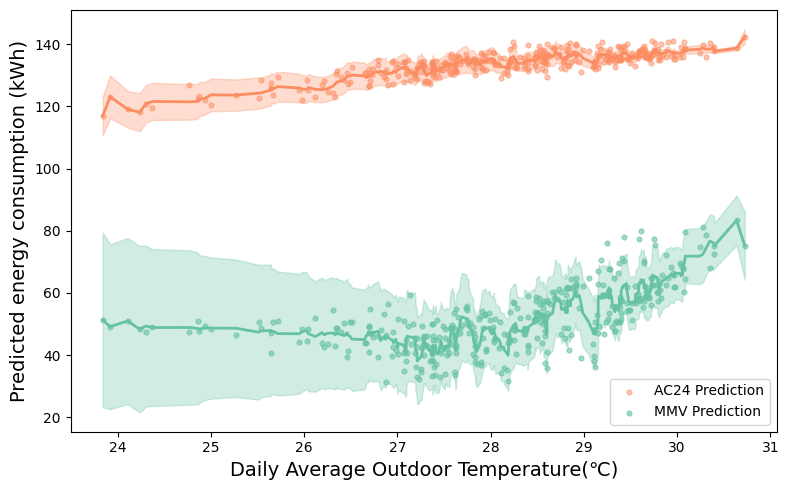

In [24]:
# Set2 color palette in dictionary form for flexibility
Set2_dict = {
    'green': '#66c2a5',
    'orange': '#fc8d62',
    'purple': '#8da0cb',
    'pink': '#e78ac3',
    'lime': '#a6d854',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'gray': '#b3b3b3'
}

# Create the upper and lower bounds for both AC24 and MMV credible regions
# For MMV
amy23_daily['mmv_UB'] = scalerY.inverse_transform(pred_mmv_mean + confint * np.sqrt(pred_mmv_var))
amy23_daily['mmv_LB'] = scalerY.inverse_transform(pred_mmv_mean - confint * np.sqrt(pred_mmv_var))
amy23_daily.loc[amy23_daily['mmv_LB'] < 0, 'mmv_LB'] = 0  # Set lower bound to 0 where necessary

# For AC24 (assuming similar variance prediction for AC24)
amy23_daily['ac_UB'] = scalerYbase.inverse_transform(pred_ac_mean + confint * np.sqrt(pred_ac_var))
amy23_daily['ac_LB'] = scalerYbase.inverse_transform(pred_ac_mean - confint * np.sqrt(pred_ac_var))
amy23_daily.loc[amy23_daily['ac_LB'] < 0, 'ac_LB'] = 0  # Set lower bound to 0 where necessary

# Now sort amy23_daily by 'P53 OutdoorTempAve' to ensure a smooth plot
amy23_daily_sorted = amy23_daily.sort_values(by='P53 OutdoorTempAve')

# Apply 5-point moving average to smooth both AC24 and MMV predictions and credible regions
window_size = 8

# Smooth the MMV prediction curve and credible region using rolling mean
mmv_mean_smooth = amy23_daily_sorted['pred_MMV'].rolling(window=window_size, center=True).mean()
mmv_UB_smooth = amy23_daily_sorted['mmv_UB'].rolling(window=window_size, center=True).mean()
mmv_LB_smooth = amy23_daily_sorted['mmv_LB'].rolling(window=window_size, center=True).mean()

# Smooth the AC24 prediction curve and credible region using rolling mean
ac_mean_smooth = amy23_daily_sorted['pred_AC'].rolling(window=window_size, center=True).mean()
ac_UB_smooth = amy23_daily_sorted['ac_UB'].rolling(window=window_size, center=True).mean()
ac_LB_smooth = amy23_daily_sorted['ac_LB'].rolling(window=window_size, center=True).mean()

# Fill the NaN values at the beginning with the original data
mmv_mean_smooth.fillna(amy23_daily_sorted['pred_MMV'], inplace=True)
mmv_UB_smooth.fillna(amy23_daily_sorted['mmv_UB'], inplace=True)
mmv_LB_smooth.fillna(amy23_daily_sorted['mmv_LB'], inplace=True)

ac_mean_smooth.fillna(amy23_daily_sorted['pred_AC'], inplace=True)
ac_UB_smooth.fillna(amy23_daily_sorted['ac_UB'], inplace=True)
ac_LB_smooth.fillna(amy23_daily_sorted['ac_LB'], inplace=True)

# Plot the predictions for AC24 and MMV with smoothed confidence intervals
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Choose colors for AC24 and MMV from Set2 palette
Colorac = Set2_dict['orange']  # You can change this to another color like 'green', 'purple', etc.
Colormmv = Set2_dict['green']  # Similarly, you can change this to 'pink', 'gray', etc.

# Plot the confidence intervals (no labels for these regions)
ax.fill_between(amy23_daily_sorted['P53 OutdoorTempAve'], ac_LB_smooth, ac_UB_smooth, color=Colorac, alpha=0.3)
ax.fill_between(amy23_daily_sorted['P53 OutdoorTempAve'], mmv_LB_smooth, mmv_UB_smooth, color=Colormmv, alpha=0.3)

# Scatter plot for AC24 and MMV predictions with labels for legend
ax.scatter(amy23_daily_sorted['P53 OutdoorTempAve'], amy23_daily_sorted['pred_AC'], c=Colorac, label='AC24 Prediction', alpha=0.5, s=12)
ax.scatter(amy23_daily_sorted['P53 OutdoorTempAve'], amy23_daily_sorted['pred_MMV'], c=Colormmv, label='MMV Prediction', alpha=0.6, s=12)

# Plot the smoothed regression curves with thicker lines
ax.plot(amy23_daily_sorted['P53 OutdoorTempAve'], ac_mean_smooth, color=Colorac, linewidth=2)  # Line thickness increased
ax.plot(amy23_daily_sorted['P53 OutdoorTempAve'], mmv_mean_smooth, color=Colormmv, linewidth=2)  # Line thickness increased

# Add labels and move the legend outside the plot
ax.set_xlabel('Daily Average Outdoor Temperature(℃)',fontsize=14)
ax.set_ylabel('Predicted energy consumption (kWh)',fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Legend placed outside the plot

# Position the legend in the lower right
ax.legend(loc='lower right')  # Legend placed in the lower right of the plot

plt.tight_layout()
#plt.savefig('plot_image.png', dpi=300)

### Result Graph Adjustment

C:\Users\bdgleiy.NUSSTF\AppData\Local\Temp\ipykernel_25476\1751990420.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels, fontsize=14)
C:\Users\bdgleiy.NUSSTF\AppData\Local\Temp\ipykernel_25476\1751990420.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels, fontsize=14)


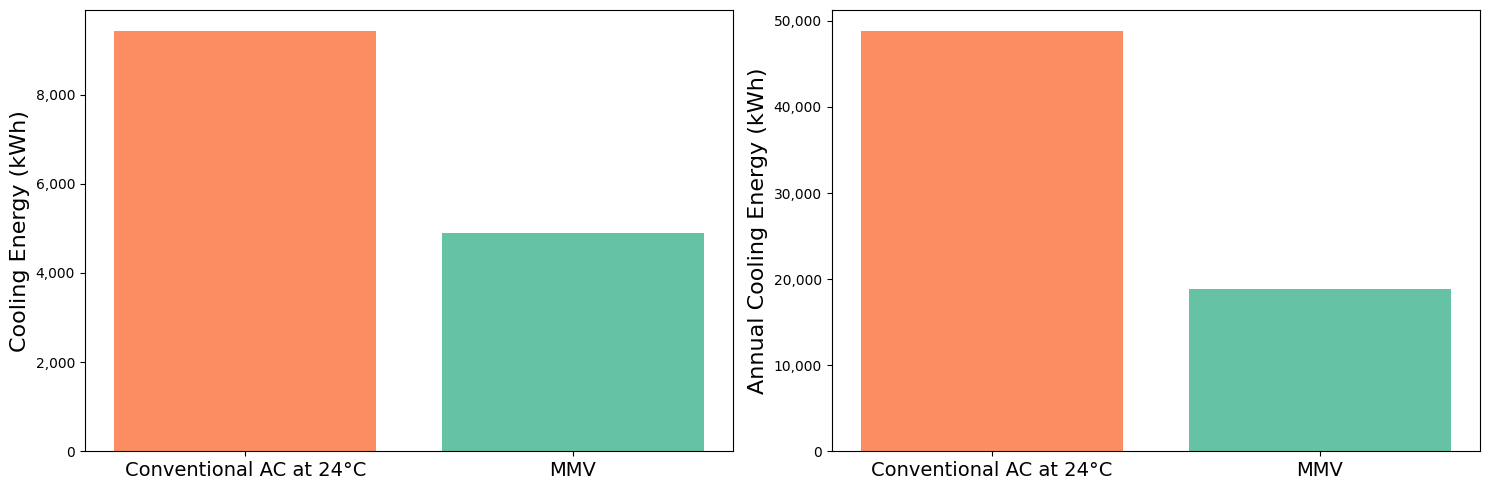

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Data
labels = ['Conventional AC at 24°C', 'MMV']
experiment_data = [9423.571368, 4888.61]
annual_simulation_data = [48822.1, 18830.34929]

# Set the color palette from Seaborn and reverse the order
palette = sns.color_palette("Set2")

# Set the font to DejaVu Sans
plt.rcParams['font.family'] = 'DejaVu Sans'

# Function to add commas to the y-axis
def thousands_formatter(x, pos):
    return f'{int(x):,}'

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart for experimental period with specific colors for each bar
bars1 = ax1.bar(labels, experiment_data, color=[palette[1], palette[0]])  # MMV (palette[0]), Conventional (palette[1])
ax1.set_ylabel('Cooling Energy (kWh)', fontsize=16)

# Set x-axis label font size
ax1.set_xticklabels(labels, fontsize=14)

# Format y-axis with commas
ax1.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Bar chart for annual simulation with specific colors for each bar
bars2 = ax2.bar(labels, annual_simulation_data, color=[palette[1], palette[0]])  # MMV (palette[0]), Conventional (palette[1])
ax2.set_ylabel('Annual Cooling Energy (kWh)', fontsize=16)

# Set x-axis label font size
ax2.set_xticklabels(labels, fontsize=14)

# Format y-axis with commas
ax2.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Adjust layout
plt.tight_layout()
#plt.show()

#plt.savefig('compare_energy.png', dpi=300)